In [73]:
import pandas as pd
import numpy as np
# import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter

In [89]:
stock_name = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'
scen_size = 10000

In [90]:
prices = data.DataReader(stock_name,'yahoo', start_date, pred_end_date)
prices = prices['Adj Close']
train_set = prices.loc[:end_date]
test_set = prices.loc[end_date:pred_end_date]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

In [91]:
# So = train_set.loc['2009-12-31']
So = train_set[-1]

In [92]:
dt = 1

In [93]:
n_of_wkdays = pd.date_range(start=pd.to_datetime(end_date,
                                                 format="%Y-%m-%d") + pd.Timedelta('1 days'),
                            end=pd.to_datetime(pred_end_date,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()
T = n_of_wkdays

In [94]:
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

In [95]:
# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

In [96]:
diffusion

{'1': array([ 0.01758033,  0.02650894,  0.0525643 ,  0.03850639,  0.01970215,
         0.00978254,  0.002899  ,  0.01681185,  0.00920983,  0.00540553,
        -0.00099719,  0.00327756,  0.01949727,  0.04635143,  0.04885978,
         0.07724032,  0.09232968,  0.10499139,  0.1164673 ,  0.13241105,
         0.11219659,  0.10514216,  0.09632738,  0.08860837,  0.1069198 ,
         0.09243408,  0.10219726,  0.11966609,  0.08510444,  0.06124252,
         0.08155777,  0.09649188,  0.10421282,  0.07499942,  0.06039492,
         0.07595818,  0.09461336,  0.10752719,  0.10699326,  0.06516997,
         0.06332085,  0.05263438,  0.04215143,  0.02580945]),
 '2': array([-0.01901668, -0.00879708, -0.05282194, -0.0590034 , -0.07647518,
        -0.05581593, -0.04377787, -0.02890854, -0.01769805,  0.00055261,
         0.00993649,  0.01986738,  0.03372459,  0.02189107,  0.00649859,
         0.00599678,  0.04164875,  0.03072447,  0.01451862,  0.01231044,
         0.00742145, -0.01267163,  0.00914996,  0.01

In [97]:
# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Adj Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index
mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)

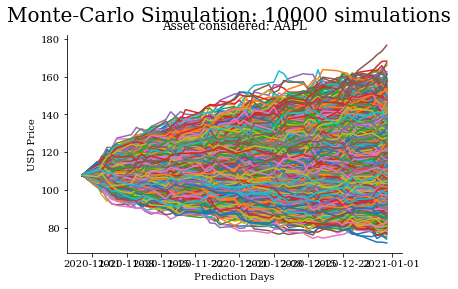

In [98]:
# Plotting the simulations
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Monte-Carlo Simulation: ' + str(scen_size) + ' simulations', fontsize=20)
plt.title('Asset considered: {}'.format(stock_name))
plt.ylabel('USD Price')
plt.xlabel('Prediction Days')
for i in range(scen_size):
    plt.plot(pd.date_range(start=train_set.index[-1],
                           end=pred_end_date,
                           freq='D').map(lambda x: x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
plt.show()

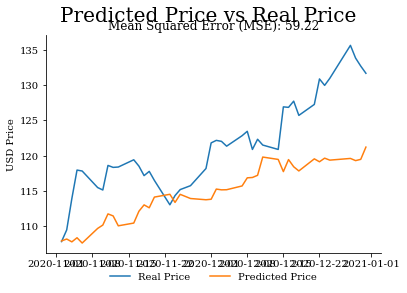

In [99]:
# Plotting the final prediction against the real price
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle('Predicted Price vs Real Price', fontsize=20)
plt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
plt.ylabel('USD Price')
plt.plot(final_df)
plt.legend(['Real Price', 'Predicted Price'],
           loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
plt.show()